In [22]:
import random
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic'

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action='ignore') 

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

import zipfile
from zipfile import ZipFile
from io import BytesIO

filepath_zip = '../data/open.zip'
with ZipFile(filepath_zip,'r') as zipObj:
    list_filenames = zipObj.namelist()
    for filename in list_filenames:
        if filename.endswith('.csv'):
            zipRead = zipObj.read(filename)
            globals()[f'{filename[5:-4]}'] = pd.read_csv(BytesIO(zipRead))
            print('df객체명 :',filename[5:-4])

df객체명 : international_trade
df객체명 : sample_submission
df객체명 : test
df객체명 : train


In [23]:
# pd.to_datetime(train['timestamp']).dt.

preprocessing

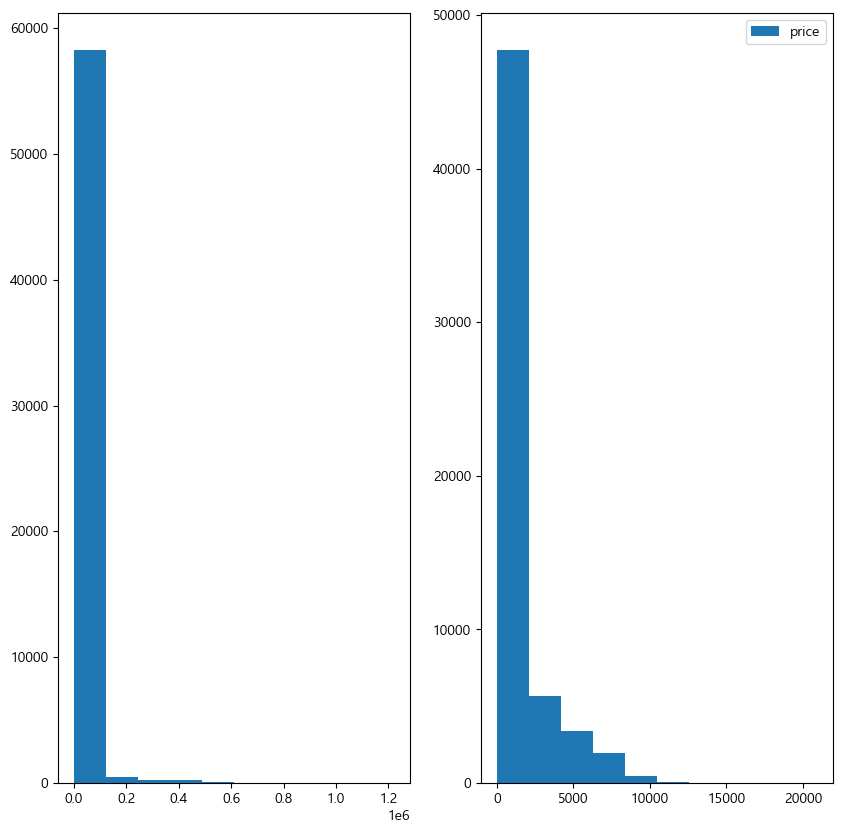

In [24]:
# supply와 price의 분포 확인
fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].hist(train['supply(kg)'].values,bins=10,label='supply')
ax[1].hist(train['price(원/kg)'].values,bins=10, label='price')
plt.legend()
plt.show()
### 둘 다 왼쪽으로 치우친 분포 >> log 변환

In [25]:
# TargetEncoding
from sklearn.preprocessing import TargetEncoder, LabelEncoder,MinMaxScaler

train_ = train.copy()

# drop columns
drop_cols = ['ID']
train_.drop(columns=drop_cols,inplace=True)

# split time data to year, month, dayofweek(요일)
train_['timestamp'] = pd.to_datetime(train_['timestamp'])
train_['year'] = train_['timestamp'].dt.year
train_['month'] = train_['timestamp'].dt.month
train_['dayofweek'] = train_['timestamp'].dt.dayofweek
train_['weekend'] = train_['dayofweek'].apply(lambda x: 1 if x in [5,6] else 0)
train_.drop('timestamp',axis=1,inplace=True)

# (Label or Target)Encoding & Scaling
encoders = {}
scalers = {}
encoding_cols = ['item','corporation','location']
for col in train_.columns:
    if col in encoding_cols: 
        encoder = LabelEncoder()  # LabelEncoding용
#         encoder = TargetEncoder(target_type='continuous',cv=5) # TargetEncoding용
        train_[col] = encoder.fit_transform(train_[col].values) # LabelEncoding용
#         train_[col] = encoder.fit_transform(train_[col].values.reshape(-1,1),   # TargetEncoding용
#                                    train_['price(원/kg)'].values.reshape(-1,1)
#                                    )
        encoders[col] = encoder
    if col in ['year','month','dayofweek','item','corporation','location']: # LabelEncoding용
#     if col in ['year','month','dayofweek']: # TargetEncoding용
        scaler = MinMaxScaler()
        train_[col] = scaler.fit_transform(np.array(train_[col]).reshape(-1,1))
        scalers[col] = scaler
    else :
        train_[col] = np.log1p(train_[col].values)
        scalers[col] = 'log변환'

# rename columns
train_.rename(columns={'price(원/kg)':'price','supply(kg)':'supply'},inplace=True)

train_

,item,corporation,location,supply,price,year,month,dayofweek,weekend
0,1.00,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.166667,0.000000
1,1.00,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.333333,0.000000
2,1.00,0.0,0.0,11.012083,7.455298,0.0,0.000000,0.500000,0.000000
3,1.00,0.0,0.0,10.126671,7.250636,0.0,0.000000,0.666667,0.000000
4,1.00,0.0,0.0,10.384462,7.131699,0.0,0.000000,0.833333,0.693147
...,...,...,...,...,...,...,...,...,...
59392,0.75,1.0,0.0,13.022413,6.150603,1.0,0.090909,0.000000,0.000000
59393,0.75,1.0,0.0,12.952716,6.276643,1.0,0.090909,0.166667,0.000000
59394,0.75,1.0,0.0,12.855741,6.354370,1.0,0.181818,0.333333,0.000000
59395,0.75,1.0,0.0,13.075735,6.261492,1.0,0.181818,0.500000,0.000000


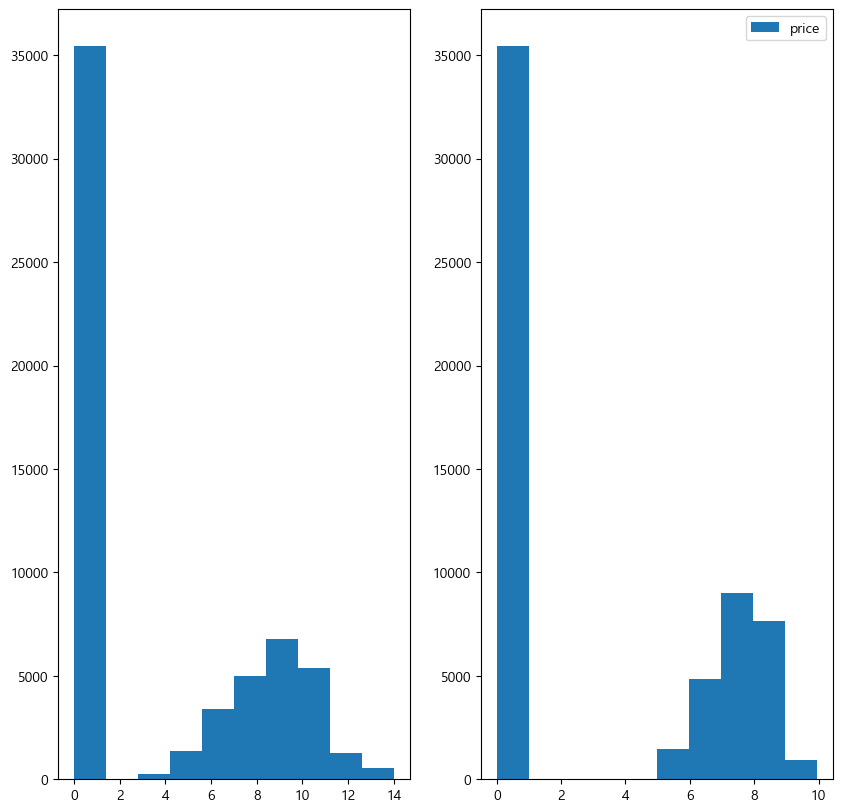

In [26]:
# supply와 price의 분포 확인
fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].hist(train_['supply'].values,bins=10,label='supply')
ax[1].hist(train_['price'].values,bins=10, label='price')
plt.legend()
plt.show()
### 둘 다 왼쪽으로 치우친 분포 >> log 변환

모델 학습 및 특성 중요도 확인

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from hyperopt import hp
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split

In [7]:
# split data as x, y
X = train_.drop('price',axis=1)
y = train_['price']

# X_train, X_val, y_train, y_val = train_test_split(X,y,
#                                                    test_size=0.2,
#                                                    random_state=156,
#                                                    shuffle=True)

X_train = X
y_train = y

In [8]:
from hyperopt import hp,STATUS_OK, fmin, tpe, Trials

# hyper parameter tuning
search_space = {
    'n_estimators':hp.quniform('n_estimators',1000,5000,500),
    'learning_rate':hp.uniform('learning_rate',0.001,0.01),
    'reg_alpha':hp.quniform('reg_alpha',0.1,1.5,0.1),
    'reg_lambda':hp.uniform('reg_lambda',0.1,5)    
}

X_train, X_val, y_train, y_val = train_test_split(X,y,
                                                   test_size=0.2,
                                                   random_state=156,
                                                   shuffle=True)

def hyperopt_objective_func(search_space):
    lgbm = lgb.LGBMRegressor(
        n_estimators=int(search_space['n_estimators']),
        boosting_type='goss',
        learning_rate=search_space['learning_rate'],
        reg_alpha=search_space['reg_alpha'],
        reg_lambda=search_space['reg_lambda']
    )
    
    lgbm.fit(X_train,y_train)
    preds = lgbm.predict(X_val)
    loss = mean_squared_error(y_val,preds,squared=False)
    return {'loss':loss, 'status':STATUS_OK}

trial_vals = Trials()

best = fmin(fn=hyperopt_objective_func,
            space=search_space,
            algo=tpe.suggest,
            max_evals=100,
            rstate=np.random.default_rng(seed=156)
           )
print(best)

100%|█████████████████████████| 100/100 [08:12<00:00,  4.93s/trial, best loss: 0.020131433396202717]
{'learning_rate': 0.009967797746703378, 'n_estimators': 4500.0, 'reg_alpha': 0.1, 'reg_lambda': 0.10799511145877227}


Model Tune for LGBM.


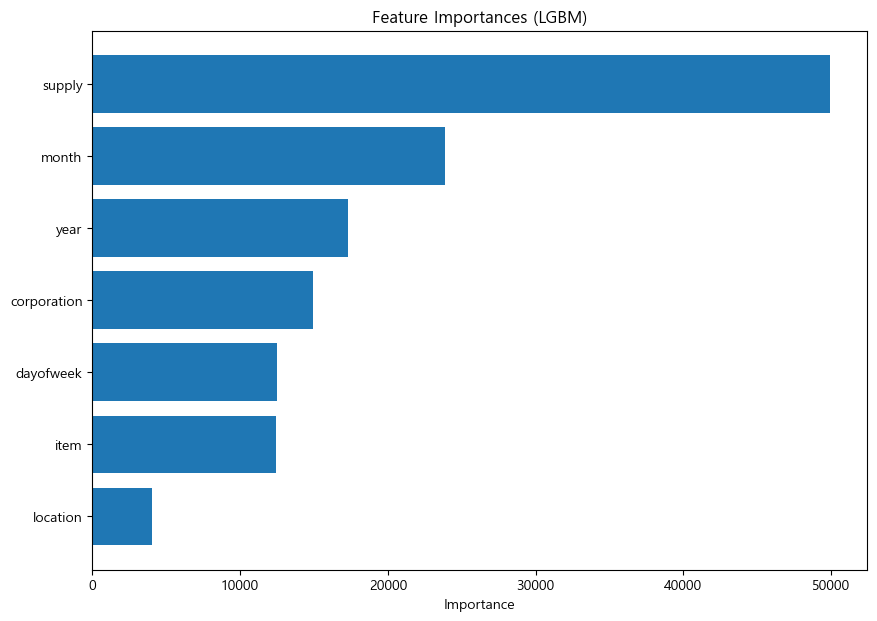

In [9]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)
    
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()
    
    return model, feature_importances

lgbm_model = lgb.LGBMRegressor(n_estimators=int(best['n_estimators']),
                                boosting_type='goss',
                                learning_rate=best['learning_rate'],
                                reg_alpha=best['reg_alpha'],
                                reg_lambda=best['reg_lambda']
                              )
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgbm_model, 'LGBM', X, y)

# lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X, y)

Feature Selection

In [10]:
threshold = 12000
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]
print(low_importance_features)
X_train_reduced = X_train.drop(columns=low_importance_features)
# X_val_reduced = X_val.drop(columns=low_importance_features)

Index(['location'], dtype='object')


In [11]:
selected_columns = X_train_reduced.columns
selected_columns

Index(['item', 'corporation', 'supply', 'year', 'month', 'dayofweek'], dtype='object')

Model Fitting & Validation

In [12]:
kf = KFold(n_splits=5, shuffle=True, random_state=156)
lgbm_model = lgb.LGBMRegressor()

preds = []
idxs = []
scores = []

for train_idx,val_idx in tqdm(kf.split(X_train_reduced), total = 5, desc="Process folds"):
    X_tr, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # fit model
    lgbm_model.fit(X_tr, y_tr)
    
    # predicts validation data
    val_pred = lgbm_model.predict(X_val)
    preds.append(val_pred)
    idxs.append(X_val.index)
    scores.append(mean_squared_error(y_val,val_pred,squared=False))

print("Validation : RMSE scores for each fold:", scores)
print("Validation : RMSE:", np.mean(scores))

Process folds: 100%|██████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.53it/s]

Validation : RMSE scores for each fold: [0.03823265167073598, 0.023933411267018315, 0.02447308372414175, 0.03322468079961336, 0.026386291113260133]
Validation : RMSE: 0.02925002371495391


Test

In [13]:
test = pd.read_csv('../data/test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')
test.head()

,ID,timestamp,item,corporation,location
0,TG_A_J_20230304,2023-03-04,TG,A,J
1,TG_A_J_20230305,2023-03-05,TG,A,J
2,TG_A_J_20230306,2023-03-06,TG,A,J
3,TG_A_J_20230307,2023-03-07,TG,A,J
4,TG_A_J_20230308,2023-03-08,TG,A,J


In [14]:
encoder, scalers

(LabelEncoder(),
 {'item': MinMaxScaler(),
  'corporation': MinMaxScaler(),
  'location': MinMaxScaler(),
  'supply(kg)': 'log변환',
  'price(원/kg)': 'log변환',
  'year': MinMaxScaler(),
  'month': MinMaxScaler(),
  'dayofweek': MinMaxScaler()})

In [15]:
test_ = test.copy()
# drop columns
drop_cols = ['ID']
test_.drop(columns=drop_cols,inplace=True)

# to_datetime
test_['timestamp'] = pd.to_datetime(test_['timestamp'])

# make supply column and fill with supply from train 
test_['supply'] = np.zeros((len(test_),1))
train__ = train.copy()
train__['timestamp'] = pd.to_datetime(train__['timestamp'])
def find_lastyear_supply(row):
    date = pd.to_datetime(f'{row["timestamp"].year-1}-{row["timestamp"].month}-{row["timestamp"].day}').date()
#     print(date)
    row['supply'] = train__[(train__['timestamp'].dt.date==date)&
                            (train__['corporation']==row['corporation'])&
                            (train__['location']==row['location']) &
                            (train__['item']==row['item'])]['supply(kg)'].sum()
#     print(row['supply'])
    return row
test_ = test_.apply(find_lastyear_supply,axis=1)

# split time data to year, month, dayofweek(요일)
test_['year'] = test_['timestamp'].dt.year
test_['month'] = test_['timestamp'].dt.month
test_['dayofweek'] = test_['timestamp'].dt.dayofweek
test_.drop('timestamp',axis=1,inplace=True)

# LabelEncoding & Scaling

encoding_cols = ['item','corporation','location']
for col in test_.columns:
    if col in encoding_cols:
        if col in encoding_cols:
            encoder = encoders[col]
            test_[col] = encoder.transform(test_[col].values)
#             test_[col] = encoder.transform(test_[col].values.reshape(-1,1))
    if col in ['year','month','dayofweek','item','corporation','location']: # LabelEncoding용
#     if col in ['year','month','dayofweek']: # TargetEncoding용
        scaler = scalers[col]
        test_[col] = scaler.transform(np.array(test_[col]).reshape(-1,1))
    else :
        test_[col] = np.log1p(test_[col].values)

# rename columns
test_.rename(columns={'price(원/kg)':'price','supply(kg)':'supply'},inplace=True)

test_

,item,corporation,location,supply,year,month,dayofweek
0,1.00,0.0,0.0,8.258681,1.0,0.181818,0.833333
1,1.00,0.0,0.0,8.804325,1.0,0.181818,1.000000
2,1.00,0.0,0.0,0.000000,1.0,0.181818,0.000000
3,1.00,0.0,0.0,9.322061,1.0,0.181818,0.166667
4,1.00,0.0,0.0,8.908830,1.0,0.181818,0.333333
...,...,...,...,...,...,...,...
1087,0.75,1.0,0.0,0.000000,1.0,0.181818,0.000000
1088,0.75,1.0,0.0,13.109523,1.0,0.181818,0.166667
1089,0.75,1.0,0.0,13.160547,1.0,0.181818,0.333333
1090,0.75,1.0,0.0,13.170927,1.0,0.181818,0.500000


In [16]:
test_reduced = test_.drop(columns=low_importance_features)
test_reduced.columns

Index(['item', 'corporation', 'supply', 'year', 'month', 'dayofweek'], dtype='object')

In [17]:
test_pred = lgbm_model.predict(test_reduced)

In [18]:
test_pred = np.expm1(test_pred)
sample_submission['answer']=np.where(test_pred<0,0,test_pred)
sample_submission

,ID,answer
0,TG_A_J_20230304,3965.870577
1,TG_A_J_20230305,3922.570503
2,TG_A_J_20230306,0.005785
3,TG_A_J_20230307,4282.378436
4,TG_A_J_20230308,4054.643678
...,...,...
1087,RD_F_J_20230327,0.004558
1088,RD_F_J_20230328,460.256373
1089,RD_F_J_20230329,460.895123
1090,RD_F_J_20230330,461.812232


In [19]:
sample_submission['answer']

0       3965.870577
1       3922.570503
2          0.005785
3       4282.378436
4       4054.643678
           ...     
1087       0.004558
1088     460.256373
1089     460.895123
1090     461.812232
1091     479.971010
Name: answer, Length: 1092, dtype: float64

In [20]:
# save sample_submission
sample_submission.set_index('ID',inplace=True)
sample_submission.to_csv('../data/my_submission3.csv')